In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [2]:
path = "datos/"
load_path = path + "{}.hdf"

electrodos = [8, 44, 80, 131, 185]

N_P = 10
N_S = 10
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)


In [3]:
# Calcular N para hacer la transformación simbólica
min_value = 2**32
max_value = -2**32
max_n_sigma = (-1, None)

for pacientes in [pacientes_P, pacientes_S]:
    for df_paciente in pacientes:
        for idx, df_ in df_paciente.groupby(["paciente", "epoch", "sensor"]):
            s = df_["valores"]
            min_value = min(s.min(), min_value)
            max_value = max(s.max(), max_value)
            max_n_sigma = max((len(s), s.std()), max_n_sigma)
            
print(min_value, max_value, max_n_sigma)


-0.000147632358962 0.000190491369934 (201, 0.00010227410079856465)


In [4]:
N = math.ceil((max_value - min_value) / (max_n_sigma[1] * max_n_sigma[0] ** (-1/3)))
print(N)
step = (max_value - min_value) / (N-1)
print(step)

20
1.77959857314e-05


In [5]:
def transformacion_simbolica(v):
    simbolos = (v - min_value) // step
    simbolos[simbolos == N] = N - 1
    return simbolos
    
for pacientes in [pacientes_P, pacientes_S]:
    for i, df_p in enumerate(pacientes):
        print("Paciente", i, end="\r")
        df_p["simbolo"] = df_p.groupby(["paciente", "epoch", "sensor"]).apply(transformacion_simbolica)

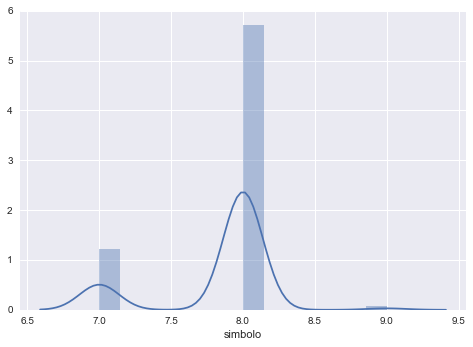

In [6]:
sns.distplot(pacientes_P[0].loc[0,0,8,:]['simbolo'])
sns.plt.show()

In [7]:
for pacientes in [pacientes_P, pacientes_S]:
    for i, df_p in enumerate(pacientes):
        df_p['repeticiones'] = df_p.groupby(["paciente", "epoch","sensor","simbolo"]).transform('count')['valores']
        df_p['total'] = df_p.groupby(["paciente", "epoch","sensor"]).transform('count')['valores']
        df_p['probabilidad'] = df_p['repeticiones'] / df_p['total']
df_p.head()

valores  simbolo  repeticiones  total  \
paciente epoch sensor tiempo                                               
19       0     8      0      -9.381955e-07      8.0          79.0  201.0   
                      1      -1.561448e-06      8.0          79.0  201.0   
                      2      -1.379147e-06      8.0          79.0  201.0   
                      3      -1.090349e-06      8.0          79.0  201.0   
                      4      -1.750849e-06      8.0          79.0  201.0   

                              probabilidad  
paciente epoch sensor tiempo                
19       0     8      0           0.393035  
                      1           0.393035  
                      2           0.393035  
                      3           0.393035  
                      4           0.393035

In [8]:
def calcular_informacion(df_):
    df_ = df_.groupby("simbolo").first()
    p = df_["probabilidad"]
    return -sum(p * np.log(p)) 

entropias_P = []
entropias_S = []
for pacientes, entropias in [(pacientes_P, entropias_P), (pacientes_S, entropias_S)]:
    for i, df_p in enumerate(pacientes):
        print(i)
        s_e = df_p.groupby(["paciente", "epoch", "sensor"]).apply(calcular_informacion)
        entropias.append(s_e)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [9]:
prom_entropias_P = []
prom_entropias_S = []
for entropias, prom_entropias in [(entropias_P, prom_entropias_P), (entropias_S, prom_entropias_S)]:
    for s in entropias:
        prom_entropias.append(s.groupby(["sensor"]).mean())
        
prom_entropias_P[0]

sensor
8      0.502578
44     0.465535
80     0.450756
131    0.471716
185    0.516775
dtype: float64

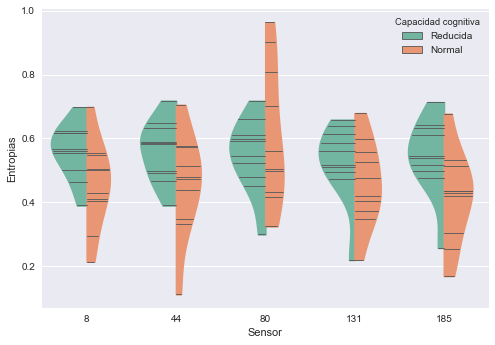

In [10]:

df_punto_a = pd.DataFrame({
    "Entropias": [x for s in (prom_entropias_P + prom_entropias_S) for x in s.values],
    "Capacidad cognitiva": ["Reducida" for s in prom_entropias_P for x in s.values] + ["Normal" for s in prom_entropias_P for x in s.values],
    "Sensor": [x for s in (prom_entropias_P + prom_entropias_S) for x in s.index]
})

sns.violinplot(x="Sensor", y="Entropias", hue="Capacidad cognitiva", data=df_punto_a, 
               split=True, palette="Set2", inner="stick", cut=0)
sns.plt.show()

In [13]:
#Evaluo la media de información por sensor comparando los individuos con capacidad cognitiva reducida y normal
#Uso rank sum con hipótesis nula: "Ambas muestras tienen la misma media"

for s in electrodos:
    x = df_punto_a[(df_punto_a.Sensor == s) & (df_punto_a['Capacidad cognitiva'] == 'Reducida')].Entropias
    y = df_punto_a[(df_punto_a.Sensor == s) & (df_punto_a['Capacidad cognitiva'] != 'Reducida')].Entropias
    _, p = scipy.stats.ranksums(x,y)
    print('p-valor misma media para sensor {}: {}'.format(s,p))
    
#Se ve que los electrodos 8, 44 y 185 pueden ser más útiles para diferenciar los individuos

p-valor misma media para sensor 8: 0.0493661947519327
p-valor misma media para sensor 44: 0.06964240479832813
p-valor misma media para sensor 80: 0.8205958397554409
p-valor misma media para sensor 131: 0.22647606604348625
p-valor misma media para sensor 185: 0.028365505605209992


In [189]:
#Todos los electrodos comparten los mismos símbolos, se promedian por electrodo para todos los individuos
#pacientes_P,pacientes_S
df_P = pd.concat(pacientes_P)
df_SP = df_P.groupby(["sensor","tiempo"]).mean().drop(["simbolo", "repeticiones", "total", "probabilidad"], axis=1)
df_S = pd.concat(pacientes_S)
df_SS = df_S.groupby(["sensor", "tiempo"]).mean().drop(["simbolo", "repeticiones", "total", "probabilidad"], axis=1)

In [200]:
df_SS.head()

valores
sensor tiempo              
8      0      -8.804419e-09
       1      -2.458968e-08
       2      -2.306229e-08
       3      -1.044884e-08
       4       3.611096e-09

In [233]:
# Calcular N para hacer la transformación simbólica
min_value = 2**32
max_value = -2**32
max_n_sigma = (-1, None)

v_S = df_SS.valores

N_S = math.ceil(v_S.max() - v_S.min() / (v_S.std() * len(v_S) ** (-1/3)))
v_P = df_SP.valores
N_P = math.ceil(v_P.max() - v_P.min() / (v_P.std() * len(v_P) ** (-1/3))) 

print(N_S,N_P)

26 24


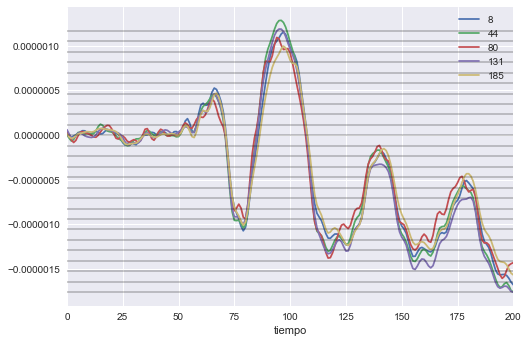

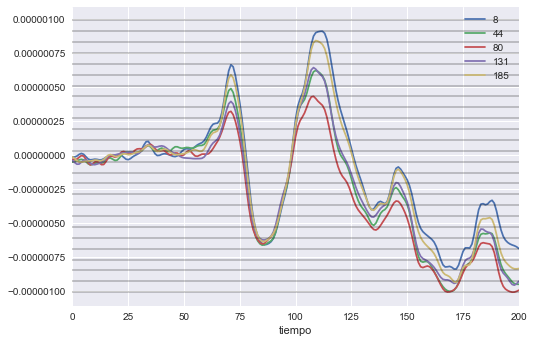

In [250]:
#Las Lineas indican la separacion en símbolos
fig, ax = sns.plt.subplots(1,1) 
df_SS.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SS.groupby('sensor')])
step = (v_S.max()-v_S.min()) / N_S
start = v_S.min()
for i in range(N_S):
    sns.plt.plot((0,200),(start + i*step,start + i*step), 'k-', lw = 0.4)

sns.plt.show()

fig, ax = sns.plt.subplots(1,1) 
df_SP.reset_index().groupby("sensor").plot(x="tiempo", y="valores", ax=ax)
sns.plt.legend([v[0] for v in df_SP.groupby('sensor')])
step = (v_P.max()-v_P.min()) / N_P
start = v_P.min()
for i in range(N_S):
    sns.plt.plot((0,200),(start + i*step,start + i*step), 'k-', lw = 0.4)

sns.plt.show()

In [251]:
df_SS

valores
sensor tiempo              
8      0      -8.804419e-09
       1      -2.458968e-08
       2      -2.306229e-08
       3      -1.044884e-08
       4       3.611096e-09
       5       1.802263e-08
       6       3.529605e-08
       7       4.930620e-08
       8       4.788565e-08
       9       3.037569e-08
       10      1.457106e-08
       11      1.812386e-08
       12      3.568233e-08
       13      4.374409e-08
       14      3.061274e-08
       15      1.323813e-08
       16      1.682503e-08
       17      4.191882e-08
       18      6.220840e-08
       19      5.702206e-08
       20      3.605998e-08
       21      2.335545e-08
       22      2.210860e-08
       23      8.922743e-09
       24     -3.280098e-08
       25     -8.459732e-08
       26     -1.100452e-07
       27     -9.812601e-08
       28     -7.703095e-08
       29     -7.900698e-08
...                     ...
185    171    -9.608521e-07
       172    -8.689682e-07
       173    -7.854679e-07
       174    -7.247096e-07
       175    -6.716946e-07
       176    -6.064752e-07
       177    -5.308133e-07
       178    -4.665992e-07
       179    -4.329474e-07
       180    -4.324000e-07
       181    -4.598192e-07
       182    -5.168739e-07
       183    -6.103858e-07
       184    -7.364308e-07
       185    -8.714208e-07
       186    -9.835596e-07
       187    -1.055100e-06
       188    -1.094615e-06
       189    -1.128685e-06
       190    -1.180769e-06
       191    -1.254286e-06
       192    -1.331826e-06
       193    -1.389683e-06
       194    -1.416227e-06
       195    -1.420660e-06
       196    -1.426085e-06
       197    -1.452056e-06
       198    -1.499138e-06
       199    -1.546541e-06
       200    -1.565470e-06

[1005 rows x 1 columns]

In [12]:
l1 = pacientes_P[:1]
l2 = pacientes_S[:1]

a, b = [], []
for k, e in enumerate(electrodos):
    print("Electrodo", k + 1, "de", len(electrodos))
    for df1 in l1:
        p1 = df1.index.values[0][0]
        aux = df1.loc[p1,:2,e,:]["simbolo"]
        total = aux.shape[0]
        for i, t1 in enumerate(aux):
            if i % 50 == 0:
                print(i, "de", total, end="\r")
            p2 = df2.index.values[0][0]
            for t2 in df2.loc[p2,:2,e,:]["simbolo"]:
                a.append(int(t1))
                b.append(int(t2))
        print()
    x = np.array(a)
    y = np.array(b)

    sns.jointplot(x, y, color="k", xlim=[0, 1900], ylim=[0, 1900])
    sns.plt.show()

Electrodo 1 de 5


NameError: name 'df2' is not defined